In [6]:
#################### LIBRARIES ####################

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, sum, when, max, split

from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import ChiSquareTest

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier



from functools import reduce

In [7]:
#################### HELPER FUNCTIONS ####################

def true_positives(df, label_col, prediction_col):
    return df.where((F.col(label_col) == 1) & (F.col(prediction_col) == 1)).count()

def true_negatives(df, label_col, prediction_col):
    return df.where((F.col(label_col) == 0) & (F.col(prediction_col) == 0)).count()

def false_positives(df, label_col, prediction_col):
    return df.where((F.col(label_col) == 0) & (F.col(prediction_col) == 1)).count()

def false_negatives(df, label_col, prediction_col):
    return df.where((F.col(label_col) == 1) & (F.col(prediction_col) == 0)).count()

# Preprocessing Function

def preprocess(df):
    # Find the columns with null values
    null_columns = [column for column in df.columns if df.filter(df[column].isNull()).count() > 0]

    # Substitute 0 in each null value found in the SHOT_CLOCK feature:
    df = df.fillna(0, subset=null_columns)

    # Substitute the positive mean value for the negative values found in the TOUCH_TIME feature:
    positive_touch_time_mean = df.filter(F.col("TOUCH_TIME") > 0).agg(F.mean("TOUCH_TIME")).collect()[0][0]
    df = df.withColumn("TOUCH_TIME", F.when(F.col("TOUCH_TIME") < 0, F.lit(positive_touch_time_mean)).otherwise(F.col("TOUCH_TIME")))

    # GAME_CLOCK Time Conversion
    df = df.withColumn("GAME_CLOCK", F.substring(F.col("GAME_CLOCK"), 12, 8))
    df = df.withColumn("GAME_CLOCK",
                    F.expr("CAST(split(GAME_CLOCK, ':')[0] AS INT)*60 + CAST(split(GAME_CLOCK, ':')[1] AS INT)"))

    return df

In [8]:
#################### SPARK SESSION INITIATOR ####################

# Check if the SparkSession already exists
if os.path.exists("spark-session.pid"):
    # Delete the existing SparkSession
    os.remove("spark-session.pid")

# Create a new SparkSession
spark = SparkSession.builder.master("local[*]").appName("NBAShotLogs").getOrCreate()

In [9]:
############################### DEBUG ###############################

df = spark.read.csv("shot_logs.csv", header=True, inferSchema=True)
df = preprocess(df)

null_columns = [column for column in df.columns if df.filter(df[column].isNull()).count() > 0]

# Print the number of null values in each column
for column in null_columns:
    print(column, df.filter(df[column].isNull()).count())

# Check for negative values in TOUCH_TIME
print("TOUCH_TIME NEGATIVES:", df.where(col("TOUCH_TIME") < 0).show())

# Print the GAME_CLOCK column
df.select("GAME_CLOCK").show()

print(type(df))

+-------+-------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+----------------+--------------------------+--------------+---+---+-----------+---------+
|GAME_ID|MATCHUP|LOCATION|  W|FINAL_MARGIN|SHOT_NUMBER|PERIOD|GAME_CLOCK|SHOT_CLOCK|DRIBBLES|TOUCH_TIME|SHOT_DIST|PTS_TYPE|SHOT_RESULT|CLOSEST_DEFENDER|CLOSEST_DEFENDER_PLAYER_ID|CLOSE_DEF_DIST|FGM|PTS|player_name|player_id|
+-------+-------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+----------------+--------------------------+--------------+---+---+-----------+---------+
+-------+-------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+----------------+--------------------------+--------------+---+---+-----------+---------+

TOUCH_TIME NEGATIVES: None
+----------+
|GAME_CLOCK|
+----------+
|        69|
|        14|
|      

+--------+--------------------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+-----------------+--------------------------+--------------+---+---+-------------+---------+
| GAME_ID|             MATCHUP|LOCATION|  W|FINAL_MARGIN|SHOT_NUMBER|PERIOD|GAME_CLOCK|SHOT_CLOCK|DRIBBLES|TOUCH_TIME|SHOT_DIST|PTS_TYPE|SHOT_RESULT| CLOSEST_DEFENDER|CLOSEST_DEFENDER_PLAYER_ID|CLOSE_DEF_DIST|FGM|PTS|  player_name|player_id|
+--------+--------------------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+-----------------+--------------------------+--------------+---+---+-------------+---------+
|21400899|MAR 04, 2015 - CH...|       A|  W|          24|          1|     1|        69|      10.8|       2|       1.9|      7.7|       2|       made|   Anderson, Alan|                    101187|           1.3|  1|  2|brian roberts|   203148|
|21400899|MAR 04, 2015 - CH...| 

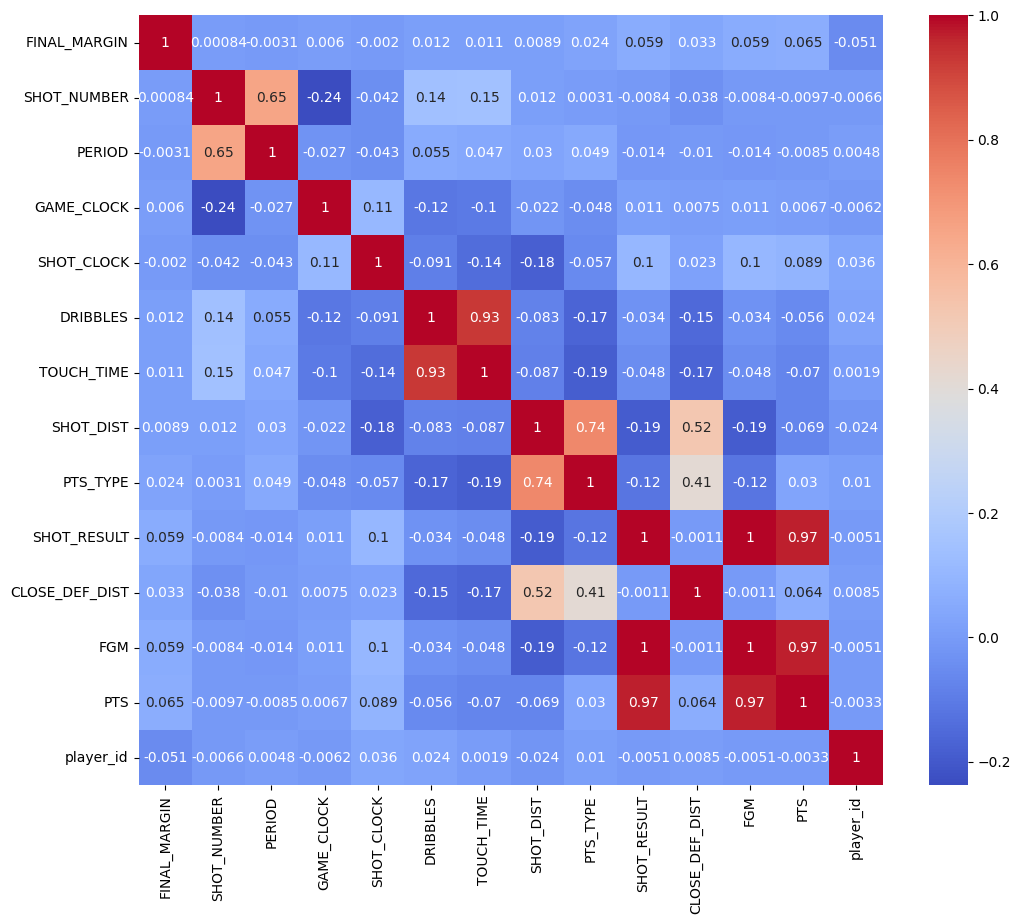

In [10]:
############################### VISUALIZNG DATA CORRELATION ###############################

# Load the DataFrame
visualize_df = spark.read.csv("shot_logs.csv", header=True, inferSchema=True)
visualize_df = preprocess(visualize_df)
visualize_df.show(5)

# Drop irrelevant columns, these columns will not affect the SHOT_RESULT (made,missed)
drop_cols = ['GAME_ID', 'LOCATION', 'W', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name', 'player_visualize_id', 'MATCHUP']
visualize_df = visualize_df.drop(*drop_cols)

# Convert the SHOT_RESULT column to a binavisualize_ry label columnvisualize_
visualize_df = visualize_df.withColumn('SHOT_RESULT', when(col('SHOT_RESULT') == 'made', 1).otherwise(0))

# Convert to pavisualize_ndas DataFrame
pdf = visualize_df.toPandas()

# Calculate the correlation matrix
corr_matrix = pdf.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

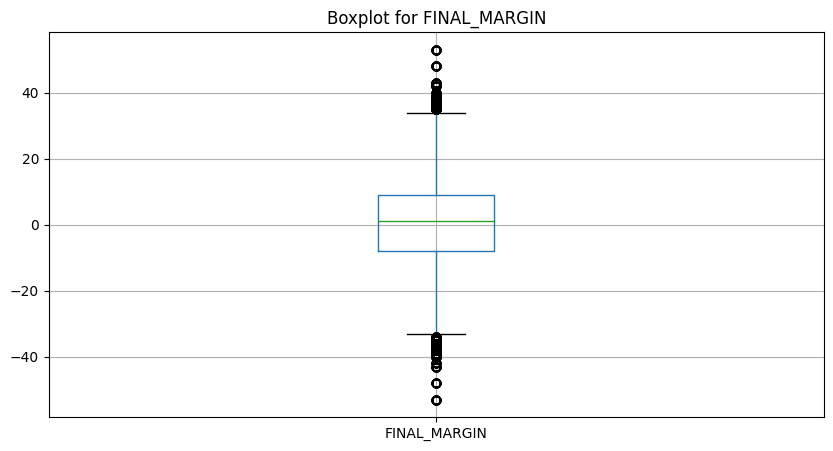

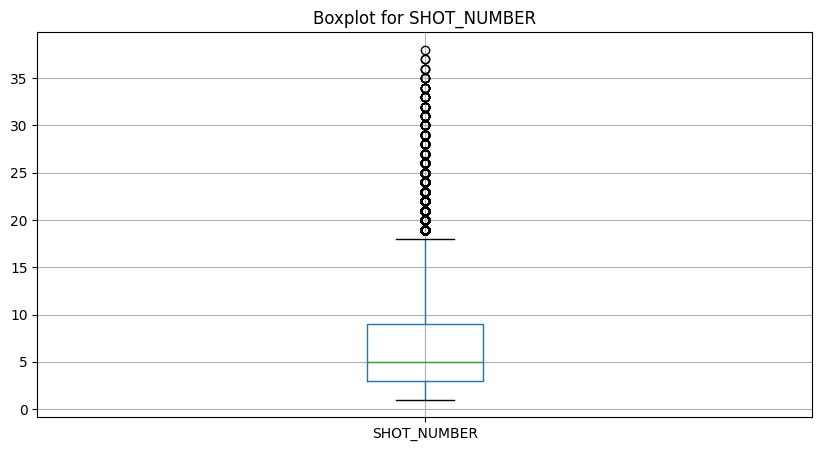

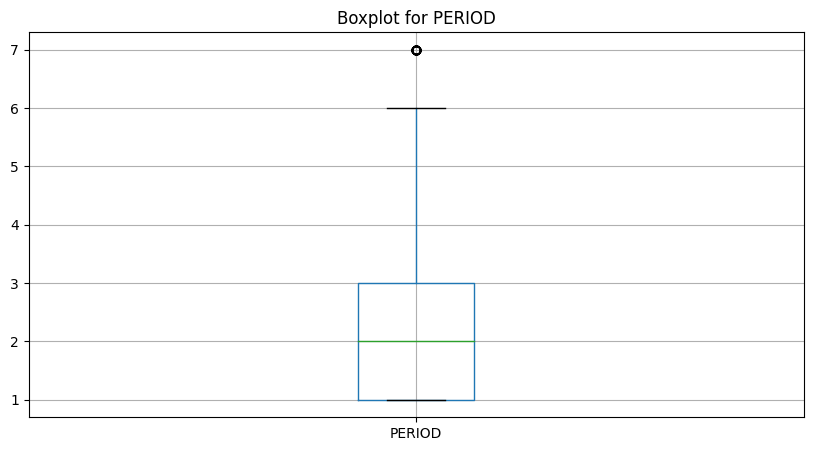

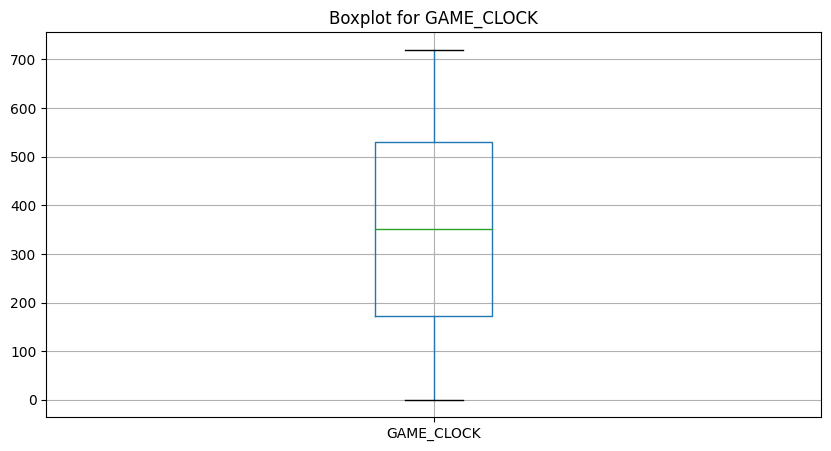

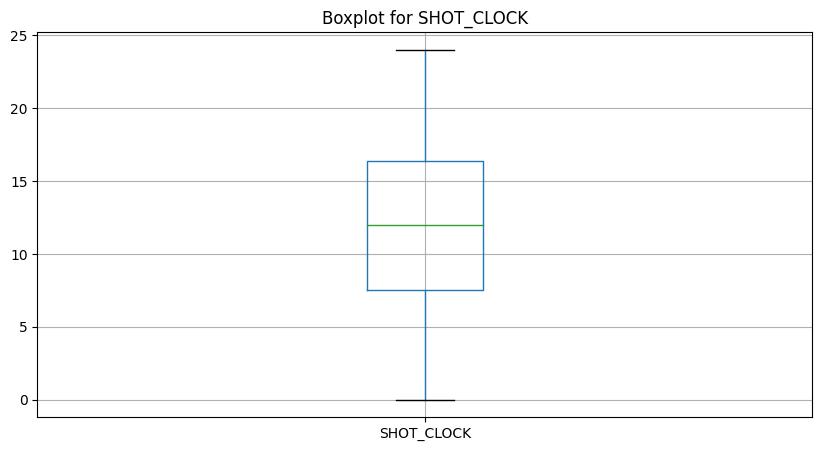

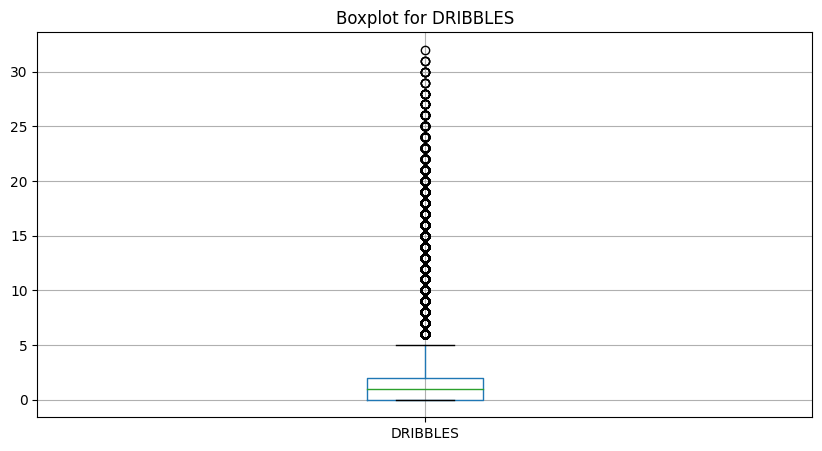

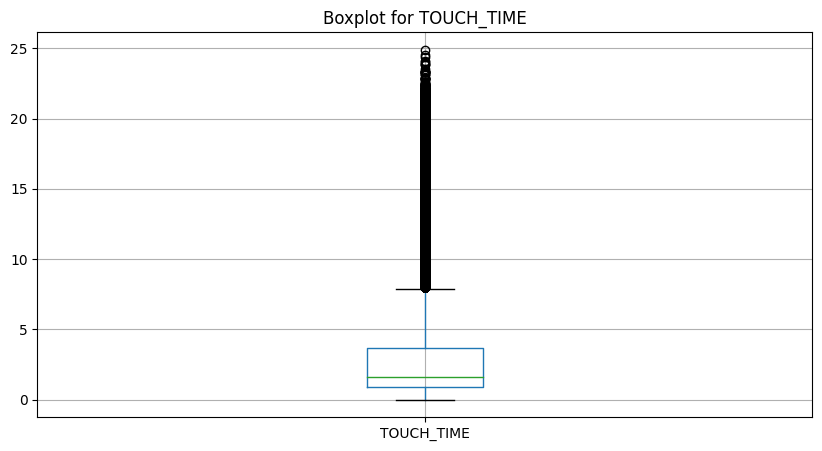

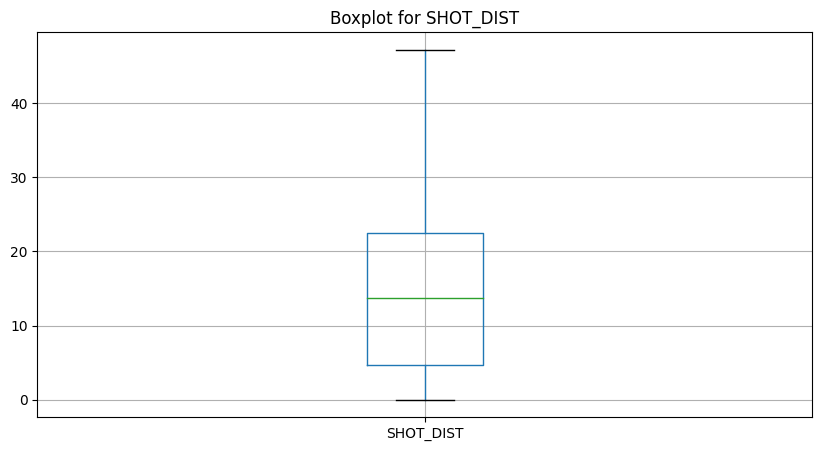

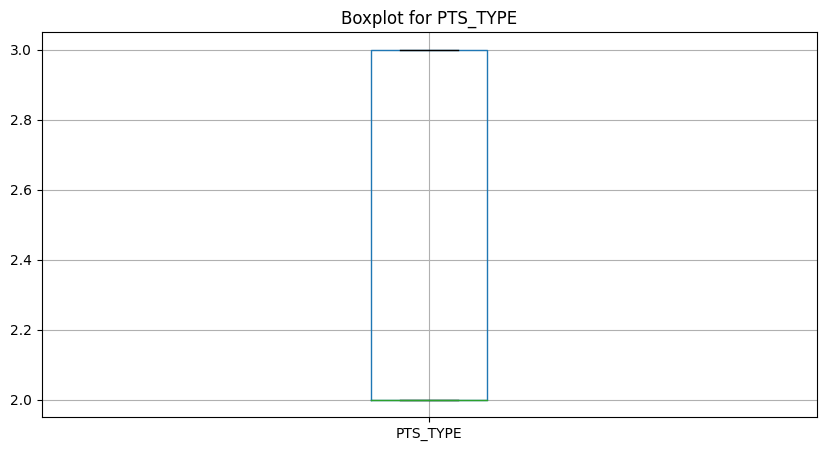

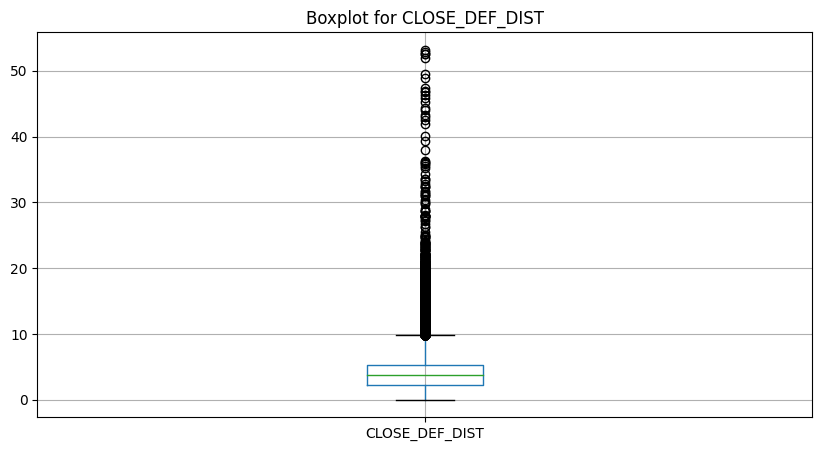

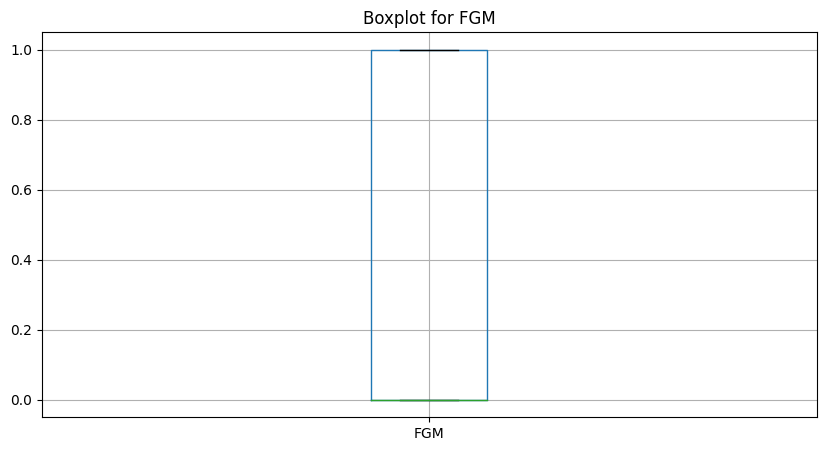

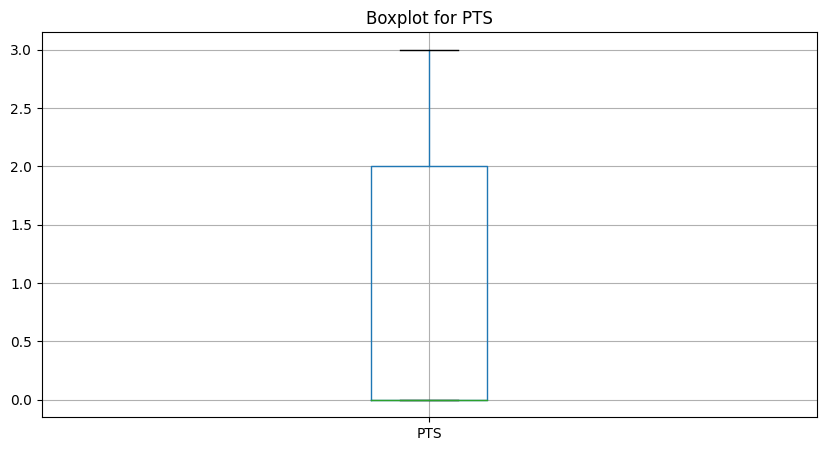

In [11]:
############################### OUTLIERS VISUALIZATION ###############################

# Read the CSV file into a DataFrame
df = spark.read.csv('shot_logs.csv', header=True, inferSchema=True)
df = preprocess(df)

# Define the list of column names to check for outliers
column_names = ["FINAL_MARGIN", "SHOT_NUMBER", "PERIOD", "GAME_CLOCK", "SHOT_CLOCK", "DRIBBLES", 
                "TOUCH_TIME", "SHOT_DIST", "PTS_TYPE", "CLOSE_DEF_DIST", "FGM", "PTS"]

# Select the relevant features
selected_features = ["FINAL_MARGIN", "SHOT_NUMBER", "PERIOD", "GAME_CLOCK", "SHOT_CLOCK", "DRIBBLES",
                    "TOUCH_TIME", "SHOT_DIST", "PTS_TYPE", "CLOSE_DEF_DIST", "FGM", "PTS"]

df = df.select(selected_features)

# Convert the PySpark DataFrame to a Pandas DataFrame
pdf = df.toPandas()

# Create boxplots for each feature including outliers
for col in pdf.columns:
    plt.figure(figsize=(10, 5))
    pdf.boxplot(column=[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [12]:
############################### PARTITION CLUSTERING ###############################

# Read the CSV file into a PySpark DataFrame
cluster_df = spark.read.csv("shot_logs.csv", header=True, inferSchema=True)
cluster_df = preprocess(cluster_df)

# Select the relevant features for clustering
selected_features = ["SHOT_CLOCK", "DRIBBLES", "SHOT_DIST", "CLOSE_DEF_DIST", "TOUCH_TIME", "SHOT_RESULT"]

# Convert the SHOT_RESULT column to a binary label column
cluster_df = cluster_df.withColumn('SHOT_RESULT', F.when(F.col('SHOT_RESULT') == 'made', 1).otherwise(0))

# Prepare the features for clustering
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Set the number of clusters
num_clusters = 5

# Create the K-Means clustering model
kmeans = KMeans(featuresCol="scaled_features", k=num_clusters, seed=1)

# Create a pipeline to preprocess the data and apply clustering
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

# Fit the pipeline to the dataset
model = pipeline.fit(cluster_df)

# Assign cluster labels to each shot
clustered_data = model.transform(cluster_df)

# Show the dataset with the assigned cluster labels
clustered_data.select("SHOT_CLOCK", "DRIBBLES", "SHOT_DIST", "CLOSE_DEF_DIST", "TOUCH_TIME", "SHOT_RESULT", "prediction").show()

+----------+--------+---------+--------------+----------+-----------+----------+
|SHOT_CLOCK|DRIBBLES|SHOT_DIST|CLOSE_DEF_DIST|TOUCH_TIME|SHOT_RESULT|prediction|
+----------+--------+---------+--------------+----------+-----------+----------+
|      10.8|       2|      7.7|           1.3|       1.9|          1|         1|
|       3.4|       0|     28.2|           6.1|       0.8|          0|         2|
|       0.0|       3|     10.1|           0.9|       2.7|          0|         2|
|      10.3|       2|     17.2|           3.4|       1.9|          0|         2|
|      10.9|       2|      3.7|           1.1|       2.7|          0|         1|
|       9.1|       2|     18.4|           2.6|       4.4|          0|         2|
|      14.5|      11|     20.7|           6.1|       9.0|          0|         0|
|       3.4|       3|      3.5|           2.1|       2.5|          1|         1|
|      12.4|       0|     24.6|           7.3|       0.8|          0|         2|
|      17.4|       0|     22

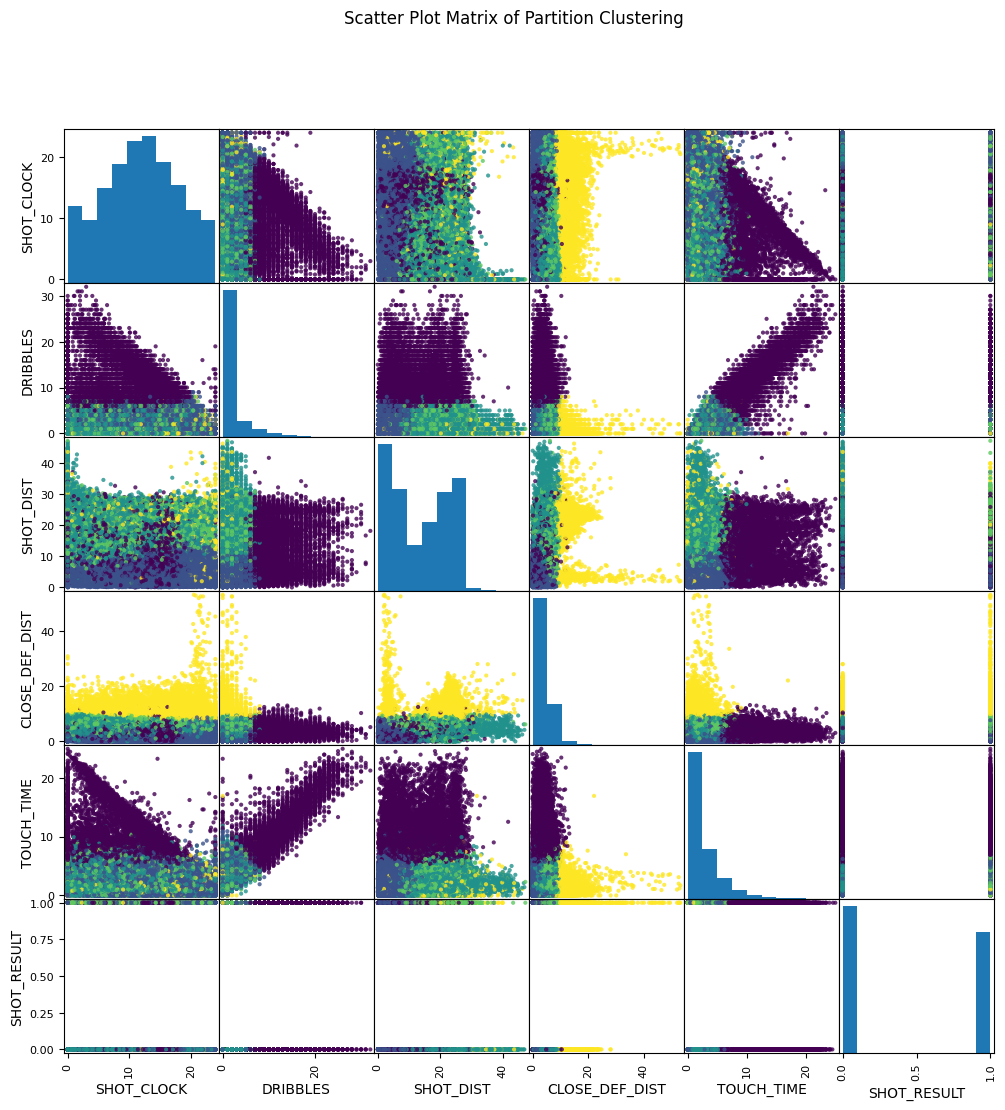

In [13]:
############################### VISUALIZING PARTITION CLUSTERING ###############################

# Convert the clustered_data DataFrame to a Pandas DataFrame
pd_clustered_data = clustered_data.toPandas()

# Create a scatter plot matrix to visualize the partition clustering
pd.plotting.scatter_matrix(pd_clustered_data[selected_features], figsize=(12, 12), diagonal='hist', alpha=0.8, c=pd_clustered_data['prediction'], cmap='viridis')

# Set the title for the scatter plot matrix
plt.suptitle('Scatter Plot Matrix of Partition Clustering')

# Save the figure
plt.savefig('partition_clustering_scatter_matrix.png')

# Show the scatter plot matrix
plt.show()

In [14]:
############################### CLASSIFICATION ###############################

# 1. Random Forest Classifier

# Initialize Spark session
spark = SparkSession.builder.master("local").appName("FGM Prediction").getOrCreate()

# Load the DataFrame
model_df = spark.read.csv("shot_logs.csv", header=True, inferSchema=True)
model_df = preprocess(model_df)

# Split the data into training and testing sets
train, test = model_df.randomSplit([0.7, 0.3], seed=42)

# Define the feature columns
feature_cols = ['SHOT_DIST', 'TOUCH_TIME', 'CLOSE_DEF_DIST', 'SHOT_CLOCK']

# Create a VectorAssembler to combine the feature columns into a single feature vector
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create the RandomForest classifier
rf_classifier = RandomForestClassifier(labelCol="FGM", featuresCol="features", numTrees=100)

# Create a pipeline with the VectorAssembler and RandomForest classifier
pipeline = Pipeline(stages=[vector_assembler, rf_classifier])

# Fit the pipeline to the training data
model = pipeline.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Show the predictions
predictions.select("SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_DIST", "SHOT_CLOCK", "FGM", "prediction").show()

# Create MulticlassClassificationEvaluators for accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="f1")

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

+---------+----------+--------------+----------+---+----------+
|SHOT_DIST|TOUCH_TIME|CLOSE_DEF_DIST|SHOT_CLOCK|FGM|prediction|
+---------+----------+--------------+----------+---+----------+
|     24.1|       1.7|           4.8|      16.8|  0|       0.0|
|     12.5|       0.8|           5.2|       8.4|  1|       0.0|
|      2.7|       0.7|           6.1|      12.4|  1|       1.0|
|      2.4|       4.7|           2.7|       6.7|  1|       1.0|
|     16.5|       5.6|           5.1|       8.3|  0|       0.0|
|      0.8|       0.6|           2.6|      11.5|  1|       1.0|
|     22.2|       1.0|           5.7|      14.6|  0|       0.0|
|     17.6|       2.5|          13.4|       5.0|  0|       0.0|
|     16.4|       1.6|           6.3|       5.8|  1|       0.0|
|      8.0|       5.0|           5.7|      12.5|  0|       0.0|
|     24.2|       0.9|           6.3|       5.7|  0|       0.0|
|      1.6|       2.1|           0.9|      24.0|  0|       1.0|
|      7.6|       2.1|           2.0|   

In [15]:
# 2. GBT Classifier

# Create the GBTClassifier
gbt = GBTClassifier(labelCol="FGM", featuresCol="features", maxIter=50)

# Create a pipeline with the VectorAssembler and GBTClassifier
pipeline = Pipeline(stages=[vector_assembler, gbt])

# Fit the pipeline to the training data
model = pipeline.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Show the predictions
predictions.select("SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_DIST", "SHOT_CLOCK", "FGM", "prediction").show()

# Create MulticlassClassificationEvaluators for accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="f1")

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

+---------+----------+--------------+----------+---+----------+
|SHOT_DIST|TOUCH_TIME|CLOSE_DEF_DIST|SHOT_CLOCK|FGM|prediction|
+---------+----------+--------------+----------+---+----------+
|     24.1|       1.7|           4.8|      16.8|  0|       0.0|
|     12.5|       0.8|           5.2|       8.4|  1|       0.0|
|      2.7|       0.7|           6.1|      12.4|  1|       1.0|
|      2.4|       4.7|           2.7|       6.7|  1|       1.0|
|     16.5|       5.6|           5.1|       8.3|  0|       0.0|
|      0.8|       0.6|           2.6|      11.5|  1|       1.0|
|     22.2|       1.0|           5.7|      14.6|  0|       0.0|
|     17.6|       2.5|          13.4|       5.0|  0|       0.0|
|     16.4|       1.6|           6.3|       5.8|  1|       1.0|
|      8.0|       5.0|           5.7|      12.5|  0|       1.0|
|     24.2|       0.9|           6.3|       5.7|  0|       0.0|
|      1.6|       2.1|           0.9|      24.0|  0|       1.0|
|      7.6|       2.1|           2.0|   

In [16]:
# 3. Linear Regression

# Create the Linear Regression model
lr = LinearRegression(labelCol="FGM", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Create a pipeline with the VectorAssembler and Linear Regression model
pipeline = Pipeline(stages=[vector_assembler, lr])

# Fit the pipeline to the training data
model = pipeline.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Show the predictions
predictions.select("SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_DIST", "SHOT_CLOCK", "FGM", "prediction").show()

# Round the prediction column
rounded_predictions = predictions.withColumn("rounded_prediction", F.when(F.col("prediction") >= 0.5, 1).otherwise(0))

# Calculate true positives, true negatives, false positives, and false negatives
tp = true_positives(rounded_predictions, "FGM", "rounded_prediction")
tn = true_negatives(rounded_predictions, "FGM", "rounded_prediction")
fp = false_positives(rounded_predictions, "FGM", "rounded_prediction")
fn = false_negatives(rounded_predictions, "FGM", "rounded_prediction")

# Calculate accuracy, precision, recall, and F1 score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

+---------+----------+--------------+----------+---+------------------+
|SHOT_DIST|TOUCH_TIME|CLOSE_DEF_DIST|SHOT_CLOCK|FGM|        prediction|
+---------+----------+--------------+----------+---+------------------+
|     24.1|       1.7|           4.8|      16.8|  0|0.4518629044829967|
|     12.5|       0.8|           5.2|       8.4|  1|0.4518629044829967|
|      2.7|       0.7|           6.1|      12.4|  1|0.4518629044829967|
|      2.4|       4.7|           2.7|       6.7|  1|0.4518629044829967|
|     16.5|       5.6|           5.1|       8.3|  0|0.4518629044829967|
|      0.8|       0.6|           2.6|      11.5|  1|0.4518629044829967|
|     22.2|       1.0|           5.7|      14.6|  0|0.4518629044829967|
|     17.6|       2.5|          13.4|       5.0|  0|0.4518629044829967|
|     16.4|       1.6|           6.3|       5.8|  1|0.4518629044829967|
|      8.0|       5.0|           5.7|      12.5|  0|0.4518629044829967|
|     24.2|       0.9|           6.3|       5.7|  0|0.4518629044

In [17]:
# 4. Logistic Regression

# Create the Logistic Regression model
lr = LogisticRegression(labelCol="FGM", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Create a pipeline with the VectorAssembler and Logistic Regression model
pipeline = Pipeline(stages=[vector_assembler, lr])

# Fit the pipeline to the training data
model = pipeline.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Show the predictions
predictions.select("SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_DIST", "SHOT_CLOCK", "FGM", "prediction").show()

# Create MulticlassClassificationEvaluators for accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="FGM", predictionCol="prediction", metricName="f1")

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

+---------+----------+--------------+----------+---+----------+
|SHOT_DIST|TOUCH_TIME|CLOSE_DEF_DIST|SHOT_CLOCK|FGM|prediction|
+---------+----------+--------------+----------+---+----------+
|     24.1|       1.7|           4.8|      16.8|  0|       0.0|
|     12.5|       0.8|           5.2|       8.4|  1|       0.0|
|      2.7|       0.7|           6.1|      12.4|  1|       0.0|
|      2.4|       4.7|           2.7|       6.7|  1|       0.0|
|     16.5|       5.6|           5.1|       8.3|  0|       0.0|
|      0.8|       0.6|           2.6|      11.5|  1|       0.0|
|     22.2|       1.0|           5.7|      14.6|  0|       0.0|
|     17.6|       2.5|          13.4|       5.0|  0|       0.0|
|     16.4|       1.6|           6.3|       5.8|  1|       0.0|
|      8.0|       5.0|           5.7|      12.5|  0|       0.0|
|     24.2|       0.9|           6.3|       5.7|  0|       0.0|
|      1.6|       2.1|           0.9|      24.0|  0|       0.0|
|      7.6|       2.1|           2.0|   

In [18]:
############################### MAP-REDUCE ###############################

# 1. MapReduce - Winning Teams Shooting Percentage

# Create a Spark session
spark = SparkSession.builder.master("local").appName("NBA Shot Logs Map Reduce").getOrCreate()

# Load the DataFrame
mapreduce_df = spark.read.csv("shot_logs.csv", header=True, inferSchema=True)
mapreduce_df = preprocess(mapreduce_df)

# Extract team names from the MATCHUP column
mapreduce_df = mapreduce_df.withColumn("MATCHUP_TEAMS", split(mapreduce_df.MATCHUP, " - ")[1])

# Use LOCATION feature to determine the team and opponent correctly
mapreduce_df = mapreduce_df.withColumn("TEAM", F.when(F.col("LOCATION") == "H", F.expr("substring(MATCHUP_TEAMS, 1, 3)")).otherwise(F.expr("substring(MATCHUP_TEAMS, -3)")))
mapreduce_df = mapreduce_df.withColumn("OPPONENT", F.when(F.col("LOCATION") == "H", F.expr("substring(MATCHUP_TEAMS, -3)")).otherwise(F.expr("substring(MATCHUP_TEAMS, 1, 3)")))

# Calculate the shooting percentage per game
df_grouped = mapreduce_df.groupBy("GAME_ID", "TEAM", "OPPONENT") \
    .agg(
        count("*").alias("total_shots"),
        sum(F.when(F.col("SHOT_RESULT") == "made", 1).otherwise(0)).alias("shots_made")
    ) \
    .withColumn("shooting_percentage", F.col("shots_made") / F.col("total_shots") * 100)

# Calculate the winning team in each game
winning_team = df_grouped.groupBy("GAME_ID") \
    .agg(max("shots_made").alias("max_shots_made")) \
    .join(df_grouped, on=["GAME_ID"]) \
    .filter(F.col("shots_made") == F.col("max_shots_made")) \
    .select("GAME_ID", "TEAM", "shots_made", "shooting_percentage") \
    .withColumnRenamed("TEAM", "winning_team") \
    .withColumnRenamed("shots_made", "winning_team_shots_made") \
    .withColumnRenamed("shooting_percentage", "winning_team_shooting_percentage")

# Join the results with the original dataset
result = df_grouped.join(winning_team, on=["GAME_ID"]) \
    .select("GAME_ID", "TEAM", "OPPONENT", "total_shots", "shots_made", "shooting_percentage", "winning_team", "winning_team_shots_made", "winning_team_shooting_percentage")

# Get the total shots and shots made for both teams in each game
result_both_teams = df_grouped.groupBy("GAME_ID") \
    .agg(
        sum("total_shots").alias("both_teams_total_shots"),
        sum("shots_made").alias("both_teams_shots_made")
    )

# Join the results_both_teams with the result DataFrame
result = result.join(result_both_teams, on=["GAME_ID"])

# Combine the TEAM and OPPONENT columns as "X vs Y"
result = result.withColumn("TEAM", F.concat_ws(" vs ", F.col("TEAM"), F.col("OPPONENT"))) \
    .drop("OPPONENT")

# Rename the Shots_made column
result = result.withColumnRenamed("shots_made", "SHOTS_MADE_BY_WINNING_TEAM")
result = result.withColumnRenamed("total_shots", "WINNIG_TEAM_TOTAL_SHOTS")
result = result.withColumnRenamed("winning_team", "WINNING_TEAM")
result = result.withColumnRenamed("shooting_percentage", "SHOOTING_PERCENTAGE_BY_WINNING_TEAM")

# Drop irrelevant columns
result = result.drop("both_teams_total_shots", "winning_team_shots_made", "winning_team_shooting_percentage", "both_teams_shots_made")

# Saving the results in a preferred format
result = result.select("GAME_ID", "TEAM", "WINNING_TEAM", "SHOTS_MADE_BY_WINNING_TEAM", "WINNIG_TEAM_TOTAL_SHOTS", "SHOOTING_PERCENTAGE_BY_WINNING_TEAM")

# Save results to a CSV file
result.write.csv("winning_teams_shooting_percentage.csv", header=True, mode="overwrite")

result.show()

+--------+----------+------------+--------------------------+-----------------------+-----------------------------------+
| GAME_ID|      TEAM|WINNING_TEAM|SHOTS_MADE_BY_WINNING_TEAM|WINNIG_TEAM_TOTAL_SHOTS|SHOOTING_PERCENTAGE_BY_WINNING_TEAM|
+--------+----------+------------+--------------------------+-----------------------+-----------------------------------+
|21400007|MIA vs WAS|         MIA|                        67|                    145|                 46.206896551724135|
|21400102|LAC vs SAS|         LAC|                        66|                    156|                  42.30769230769231|
|21400149|BKN vs MIA|         BKN|                        57|                    135|                  42.22222222222222|
|21400520|MIL vs PHX|         MIL|                        71|                    157|                  45.22292993630573|
|21400878|LAL vs OKC|         LAL|                        68|                    148|                  45.94594594594595|
|21400225|ATL vs NOP|   

In [19]:
mapreduce_df.show(100)

+--------+--------------------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+-------------------+--------------------------+--------------+---+---+-------------+---------+-------------+----+--------+
| GAME_ID|             MATCHUP|LOCATION|  W|FINAL_MARGIN|SHOT_NUMBER|PERIOD|GAME_CLOCK|SHOT_CLOCK|DRIBBLES|TOUCH_TIME|SHOT_DIST|PTS_TYPE|SHOT_RESULT|   CLOSEST_DEFENDER|CLOSEST_DEFENDER_PLAYER_ID|CLOSE_DEF_DIST|FGM|PTS|  player_name|player_id|MATCHUP_TEAMS|TEAM|OPPONENT|
+--------+--------------------+--------+---+------------+-----------+------+----------+----------+--------+----------+---------+--------+-----------+-------------------+--------------------------+--------------+---+---+-------------+---------+-------------+----+--------+
|21400899|MAR 04, 2015 - CH...|       A|  W|          24|          1|     1|        69|      10.8|       2|       1.9|      7.7|       2|       made|     Anderson, Alan|               

In [20]:
# 2. MapReduce - Player's average shooting distance per game
player_avg_shot_dist = mapreduce_df.groupBy("GAME_ID", "player_name") \
    .agg(
        count("*").alias("total_shots"),
        sum(F.col("SHOT_DIST")).alias("total_shot_distance")
    ) \
    .withColumn("avg_shot_distance", F.col("total_shot_distance") / F.col("total_shots")) \
    .select("GAME_ID", "player_name", "avg_shot_distance")

player_avg_shot_dist.show()

+--------+-----------------+------------------+
| GAME_ID|      player_name| avg_shot_distance|
+--------+-----------------+------------------+
|21400157|    trevor booker|              9.65|
|21400395|      enes kanter|             15.15|
|21400003|    carlos boozer| 8.184615384615386|
|21400471|       nick young|16.516666666666666|
|21400474|marreese speights|11.953846153846154|
|21400140|     andrew bogut| 5.042857142857143|
|21400715|   andre iguodala|16.077777777777776|
|21400365|   andre iguodala|             22.61|
|21400793|   draymond green|14.716666666666667|
|21400449|  thabo sefolosha|15.949999999999998|
|21400592|  dennis schroder| 6.033333333333334|
|21400124|  dennis schroder|10.809999999999999|
|21400215|     paul millsap|11.166666666666666|
|21400592|      jeff teague| 9.125000000000002|
|21400264|   kevin seraphin|               7.9|
|21400489|    rasual butler|             19.05|
|21400300|     tyreke evans|10.355555555555558|
|21400410|    terrence ross|22.518749999

In [21]:
# 3. MapReduce - Most Valuable Players in each team across the season

def mapper(row):
    player_key = (row['TEAM'], row['player_name'])
    shots_made = 1 if row['SHOT_RESULT'] == 'made' else 0
    dribbles = row['DRIBBLES']
    output = {
        'shots_made': shots_made,
        'dribbles': dribbles,
        'count': 1
    }
    return player_key, output

def reducer(accumulator, new_data):
    accumulator['shots_made'] += new_data['shots_made']
    accumulator['dribbles'] += new_data['dribbles']
    accumulator['count'] += new_data['count']
    return accumulator

# Convert mapreduce_df to be read by pd
mapreduce_df = mapreduce_df.toPandas()

# Convert the DataFrame to a list of dictionaries
data = mapreduce_df.to_dict('records')

# Assuming the dataset is a list of dictionaries called 'data'

# Step 1: Map
mapped_data = [mapper(row) for row in data]

# Step 2: Group by key
grouped_data = {}
for key, value in mapped_data:
    if key not in grouped_data:
        grouped_data[key] = []
    grouped_data[key].append(value)

# Step 3: Reduce
reduced_data = {}
for key, values in grouped_data.items():
    reduced_data[key] = reduce(reducer, values)

# Step 4: Find the most valuable player for each team
team_mvp = {}
for (team, player_name), stats in reduced_data.items():
    if team not in team_mvp or (stats['shots_made'] > team_mvp[team]['shots_made'] and stats['dribbles'] > team_mvp[team]['dribbles']):
        team_mvp[team] = {
            'player_name': player_name,
            'shots_made': stats['shots_made'],
            'dribbles': stats['dribbles']
        }

for team, mvp in team_mvp.items():
    print(f"Team: {team}\nMVP: {mvp['player_name']}\nTotal successful shots made: {mvp['shots_made']}\nTotal dribbles: {mvp['dribbles']}\n")
    
# Save the output to a CSV file
with open('MVP.csv', 'w', newline='') as csvfile:
    fieldnames = ['team', 'player_name', 'shots_made', 'dribbles']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for team, mvp in team_mvp.items():
        writer.writerow({
            'team': team,
            'player_name': mvp['player_name'],
            'shots_made': mvp['shots_made'],
            'dribbles': mvp['dribbles']
        })


Team: BKN
MVP: brook lopez
Total successful shots made: 150
Total dribbles: 192

Team: CHA
MVP: kemba walker
Total successful shots made: 137
Total dribbles: 1788

Team: ORL
MVP: victor oladipo
Total successful shots made: 162
Total dribbles: 1498

Team: BOS
MVP: avery bradley
Total successful shots made: 161
Total dribbles: 574

Team: CHI
MVP: derrick rose
Total successful shots made: 169
Total dribbles: 1649

Team: DAL
MVP: mnta ellis
Total successful shots made: 225
Total dribbles: 1610

Team: PHI
MVP: michael carter-williams
Total successful shots made: 119
Total dribbles: 1429

Team: WAS
MVP: john wall
Total successful shots made: 202
Total dribbles: 2499

Team: DEN
MVP: ty lawson
Total successful shots made: 159
Total dribbles: 1831

Team: SAS
MVP: tony parker
Total successful shots made: 129
Total dribbles: 1303

Team: CLE
MVP: kyrie irving
Total successful shots made: 235
Total dribbles: 2273

Team: NYK
MVP: carmelo anthony
Total successful shots made: 207
Total dribbles: 805



In [22]:
############################### ASSOCIATION RULES ###############################

# Load the data into a PySpark DataFrame
assoc_df = spark.read.csv("shot_logs.csv", header=True)
assoc_df = preprocess(assoc_df)

# Convert string columns to numeric indices for ChiSquareTest
indexers = []
assoc_cols = ['SHOT_RESULT', 'PERIOD', 'DRIBBLES', 'CLOSE_DEF_DIST', 'SHOT_DIST']

for col_name in assoc_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
    assoc_df = indexer.fit(assoc_df).transform(assoc_df)
    indexers.append(indexer)

# Test associations between pairs of features
for i, col1 in enumerate(assoc_cols):
    for j, col2 in enumerate(assoc_cols[i+1:], start=i+1):
        # Assemble the feature vector
        vector_assembler = VectorAssembler(inputCols=[col1 + "_index", col2 + "_index"], outputCol="features")
        assoc_df_temp = vector_assembler.transform(assoc_df)

        # Perform the Chi-square test
        chiSqResult = ChiSquareTest.test(assoc_df_temp, "features", col2 + "_index")

        # Show the results
        print(f"Chi-square test for '{col1}' and '{col2}':")
        chiSqResult.show(truncate=False)


Chi-square test for 'SHOT_RESULT' and 'PERIOD':
+--------------------------+----------------+----------------------------+
|pValues                   |degreesOfFreedom|statistics                  |
+--------------------------+----------------+----------------------------+
|[3.788396940596073E-8,0.0]|[6, 36]         |[45.46184527268424,768414.0]|
+--------------------------+----------------+----------------------------+

Chi-square test for 'SHOT_RESULT' and 'DRIBBLES':
+---------+----------------+--------------------------------------+
|pValues  |degreesOfFreedom|statistics                            |
+---------+----------------+--------------------------------------+
|[0.0,0.0]|[32, 1024]      |[276.3706469975046,4098208.0000000065]|
+---------+----------------+--------------------------------------+

Chi-square test for 'SHOT_RESULT' and 'CLOSE_DEF_DIST':
+---------------------------+----------------+--------------------------------------+
|pValues                    |degreesOfFreed